First we need to get the data. We can use the Kaggle CLI (https://github.com/Kaggle/kaggle-api).

In [265]:
run(`pip install kaggle --quiet`)
run(`kaggle competitions download titanic --quiet`)
run(`unzip -qo titanic.zip`)

Process(`unzip -qo titanic.zip`, ProcessExited(0))

In [266]:
VERSION

v"1.4.1"

In [267]:
import Pkg

In [268]:
# Pkg.add("CSV");
# Pkg.add("DataFrames");
# Pkg.add("DataFramesMeta")
# Pkg.add("Missings")
# Pkg.add("FreqTables");
# Pkg.add("GLM");
# Pkg.add("Pipe");
# Pkg.add("Plots");
# Pkg.add("StatsPlots")
# Pkg.add("XGBoost");
# Pkg.add("Zygote");

In [269]:
# TODO: How to show HTML dataframe of all columns
# TODO: add propper missing values (keep dict, make col for missing, apply on test)
# TODO: Ian Ozwald T-SNE on errors plot
# TODO: proper pipes, the _ syntax is ugly


In [320]:
using CSV, DataFrames, Pipe, Plots, Statistics, StatsBase, XGBoost, Zygote

Plots.default(legend=false, alpha=0.4, size=(300,200))
ENV["COLUMNS"]=220   # force dataframe HTML rendering to many columns; 220 is terminal characters

df = CSV.read("train.csv");

In [343]:
first(df, 10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_3,Pclass_1,Pclass_2,Embarked_S,Embarked_C,Embarked_Q
,Int64,Int64,Int64,String,String,Float64,Int64,Int64,String,Float64,String?,String,Int64,Int64,Int64,Int64,Int64,Int64
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S,1,0,0,1,0,0
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0,1,0
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,missing,S,1,0,0,1,0,0
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S,0,1,0,1,0,0
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,missing,S,1,0,0,1,0,0
6,6,0,3,"Moran, Mr. James",male,29.6991,0,0,330877,8.4583,missing,Q,1,0,0,0,0,1
7,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,1,0,1,0,0
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,missing,S,1,0,0,1,0,0
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,missing,S,1,0,0,1,0,0


In [321]:
first(df, 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String,Float64?,Int64,Int64,String,Float64,String?,String?
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,missing,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,missing,S


In [322]:
describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,Type
1,PassengerId,446.0,1,446.0,891,,,Int64
2,Survived,0.383838,0,0.0,1,,,Int64
3,Pclass,2.30864,1,3.0,3,,,Int64
4,Name,,"Abbing, Mr. Anthony",,"van Melkebeke, Mr. Philemon",891,,String
5,Sex,,female,,male,2,,String
6,Age,29.6991,0.42,28.0,80.0,,177,"Union{Missing, Float64}"
7,SibSp,0.523008,0,0.0,8,,,Int64
8,Parch,0.381594,0,0.0,6,,,Int64
9,Ticket,,110152,,WE/P 5735,681,,String


In [324]:
names(df)

12-element Array{String,1}:
 "PassengerId"
 "Survived"
 "Pclass"
 "Name"
 "Sex"
 "Age"
 "SibSp"
 "Parch"
 "Ticket"
 "Fare"
 "Cabin"
 "Embarked"

In [325]:
average_age = mean(skipmissing(df.Age))
df.Age = coalesce.(df.Age, average_age);   # coalesce replaces missing values

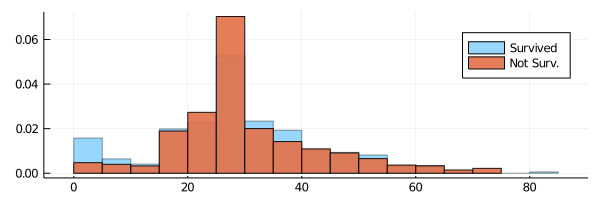

In [344]:
histogram(df[df.Survived.==1, :Age], normed=true, size=(600,200), legend=true, label="Survived")
histogram!(df[df.Survived.==0, :Age], alpha=0.9, normed=true, label="Not Surv.")

In [327]:
df.Embarked = coalesce.(df.Embarked, "S");

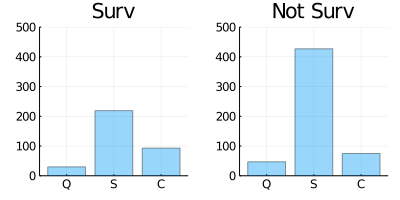

In [328]:
s = bar(countmap(df[df.Survived.==1, :Embarked]),)
ns = bar(countmap(df[df.Survived.==0, :Embarked]))
plot(s, ns, layout=2,  size=(400,200), title=["Surv" "Not Surv"], ylim=(0,500))

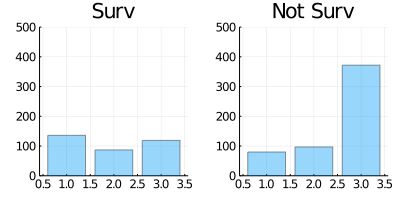

In [329]:
s = bar(countmap(df[df.Survived.==1, :Pclass]),)
ns = bar(countmap(df[df.Survived.==0, :Pclass]))
plot(s, ns, layout=2,  size=(400,200), title=["Surv" "Not Surv"], ylim=(0,500))

In [347]:
@pipe df |>
    groupby(_, :Survived) |>
    combine(_, :Fare => mean)

,Survived,Fare_mean
,Int64,Float64
1,0,22.1179
2,1,48.3954


In [331]:
first(df, 2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String,Float64,Int64,Int64,String,Float64,String?,String
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C


In [332]:
# OHE the Pclass
for i in unique(df.Pclass)
    df[:,Symbol("Pclass_"*string(i))] = Int.(df.Pclass .== i)
end

In [333]:
# OHE the embarked
for i in unique(df.Embarked)
    df[:,Symbol("Embarked_"*string(i))] = Int.(df.Embarked .== i)
end

In [337]:
first(df, 5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_3,Pclass_1,Pclass_2,Embarked_S,Embarked_C,Embarked_Q
,Int64,Int64,Int64,String,String,Float64,Int64,Int64,String,Float64,String?,String,Int64,Int64,Int64,Int64,Int64,Int64
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S,1,0,0,1,0,0
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0,1,0
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,missing,S,1,0,0,1,0,0
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S,0,1,0,1,0,0
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,missing,S,1,0,0,1,0,0


In [190]:
gender_dict = Dict("male"=>1, "female"=>0);
df.Sex = map(akey->gender_dict[akey], df.Sex);


In [339]:
cols = Not([
    :Survived,
    :Name,
    :PassengerId,
    :Pclass,
    :Ticket,
    :Cabin,
    :Embarked
])

InvertedIndex{Array{Symbol,1}}([:Survived, :Name, :PassengerId, :Pclass, :Ticket, :Cabin, :Embarked])

In [197]:
x_train = convert(Matrix{Float32}, select(df[1:800,:], cols));
y_train = convert(Array{Float32}, df[1:800,:Survived]);
x_val = convert(Matrix{Float32},select(df[801:end,:], cols));
y_val = convert(Array{Float32}, df[801:end,:Survived]);

In [198]:
train_dmat = DMatrix(x_train, label=y_train)

DMatrix(Ptr{Nothing} @0x0000000007dba440, XGBoost.var"#_setinfo#8"())

In [199]:
bst_base = xgboost(
    train_dmat,
    3,
    eta=0.3,
    objective="binary:logistic",
    eval_metric="auc"
)

[1]	train-auc:0.893250
[2]	train-auc:0.899080
[3]	train-auc:0.902066


Booster(Ptr{Nothing} @0x000000000db26850)

In [200]:
ŷ = XGBoost.predict(bst_base, x_val);

In [201]:
σ(x) = 1/(1+exp(-x))

σ (generic function with 1 method)

In [202]:
weighted_logistic_loss(x, y) = -1.5 .* y*log(σ(x)) - 1 .* (1-y)*log(1-σ(x))

weighted_logistic_loss (generic function with 1 method)

In [203]:
gradient_logistic(x, y) = gradient(weighted_logistic_loss,x,y)[1]

gradient_logistic (generic function with 1 method)

In [204]:
hess_logistic(x, y) = gradient(gradient_logistic,x,y)[1]

hess_logistic (generic function with 1 method)

In [205]:
function custom_objective(preds::Vector{Float32}, dtrain::DMatrix)
  y = get_info(dtrain, "label")
  grad = gradient_logistic.(preds, y)
  hess = hess_logistic.(preds, y)
  return grad, hess
end

custom_objective (generic function with 1 method)

In [206]:
bst = xgboost(train_dmat, 3, eta=0.3, eval_metric="auc", obj=custom_objective)

[1]	train-auc:0.892897
[2]	train-auc:0.899565
[3]	train-auc:0.912532


Booster(Ptr{Nothing} @0x000000000dd3d4d0)

In [350]:
function evaluate(y, ŷ; threshold=0.5)
    out = zeros(Int64, 2, 2)
    ŷ = Int.(ŷ.>=threshold)
    out[1,1]=sum((y.==0).&(ŷ.==0))
    out[2,2]=sum((y.==1).&(ŷ.==1))
    out[2,1]=sum((y.==1).&(ŷ.==0))
    out[1,2]=sum((y.==0).&(ŷ.==1))
    r0 = out[1,1]/(out[1,1]+out[1,2])
    p0 = out[1,1]/(out[1,1]+out[2,1])
    f0 = 2*p0*r0/(p0+r0)
    r1 = out[2,2]/(out[2,2]+out[2,1])
    p1 = out[2,2]/(out[2,2]+out[1,2])
    f1 = 2*r1*p1/(p1+r1)
    println("Weighted f1 = ", round((sum(y .== 0.0)/length(y)) * f0 + (sum(y .== 1.0)/length(y)) * f1, digits=3))
    println("Accuracy =", (out[2,2]+out[1,1])/sum(out))
    out
end                    

evaluate (generic function with 1 method)

In [353]:
cm = evaluate(y_val, ŷ)

Weighted f1 = 0.845
Accuracy =0.8461538461538461


2×2 Array{Int64,2}:
 51   6
  8  26

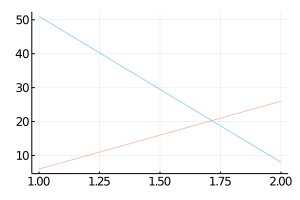

In [354]:
plot(cm)

In [93]:
sort(unique(df.Embarked))

3-element Array{String,1}:
 "C"
 "Q"
 "S"

In [83]:
DataFrame(transpose(indicatormat(df.Embarked)))

,x1,x2,x3
,Bool,Bool,Bool
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1
6,0,1,0
7,0,0,1
8,0,0,1
9,0,0,1


In [84]:
zz = [1;2;3;2;1]; zz .== sort(unique(zz))'

5×3 BitArray{2}:
 1  0  0
 0  1  0
 0  0  1
 0  1  0
 1  0  0

In [85]:
zz = [1;2;3;2;1];

In [86]:
zz

5-element Array{Int64,1}:
 1
 2
 3
 2
 1

In [89]:
sort(unique(zz))'

1×3 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 1  2  3